In [1]:
import sys
import os
import uproot
import glob
import pandas as pd
import numpy as np
import ROOT
import matplotlib.pyplot as plt
import json
os.system("")

def prGreen(prt): print("\033[92m {}\033[00m" .format(prt))

Welcome to JupyROOT 6.18/00


In [2]:
def plot_mva(df, column, bins, logscale=False, ax=None, title=None, ls='dashed', alpha=0.5, sample='',cat="Matchlabel",Wt="Wt"):
    histtype="bar" 
    if sample is 'test':
        histtype="step"      
    if ax is None:
        ax = plt.gca()
    for name, group in df.groupby(cat):
        if name == 0:
            label="background"
        else:
            label="signal"
        group[column].hist(bins=bins, histtype=histtype, alpha=1,
                           label=label+' '+sample, ax=ax, density=True, ls=ls, weights =group[Wt],linewidth=2)
    #ax.set_ylabel("density")
    ax.set_xlabel(column)
    ax.legend(fontsize=10)
    ax.set_title(title)
    if logscale:
        ax.set_yscale("log", nonposy='clip')

In [3]:
def plot_roc_curve(df, score_column, tpr_threshold=0, ax=None, color=None, linestyle='-', label=None,cat="Matchlabel",Wt="Wt"):
    from sklearn import metrics
    if ax is None: ax = plt.gca()
    if label is None: label = score_column
    fpr, tpr, thresholds = metrics.roc_curve(df[cat], df[score_column],sample_weight=df[Wt])
    mask = tpr > tpr_threshold
    fpr, tpr = fpr[mask], tpr[mask]
    auc=metrics.auc(fpr, tpr)
    label=label+' auc='+str(round(auc*100,1))+'%'
    ax.plot(tpr, fpr, label=label, color=color, linestyle=linestyle,linewidth=4)
    ax.legend()
    return auc

def plot_single_roc_point(df, var='Fall17isoV1wpLoose', 
                          ax=None , marker='o', 
                          markersize=6, color="red", label='', cat="Matchlabel",Wt="Wt"):
    backgroundpass=df.loc[(df[var] == 1) & (df[cat] == 0),Wt].sum()
    backgroundrej=df.loc[(df[var] == 0) & (df[cat] == 0),Wt].sum()
    signalpass=df.loc[(df[var] == 1) & (df[cat] == 1),Wt].sum()
    signalrej=df.loc[(df[var] == 0) & (df[cat] == 1),Wt].sum()
    backgroundrej=backgroundrej/(backgroundpass+backgroundrej)
    signaleff=signalpass/(signalpass+signalrej)
    ax.plot([signaleff], [1-backgroundrej], marker=marker, markersize=markersize, label=label)
    ax.legend()

In [4]:
TrainConfig=sys.argv[1]
TrainConfig="TrainConfig"
prGreen("Importing settings from "+ TrainConfig)
exec("from "+TrainConfig+" import *")
if Debug==True:
    prGreen("Running in debug mode : Only every 10th event will be used")

 Importing settings from TrainConfig


W0312 19:29:40.847973 140577837160256 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


 Running in debug mode : Only every 10th event will be used


In [5]:

prGreen("Making output directory")
os.system("mkdir -p " + OutputDirName)
os.system("cp TrainConfig.py ./"+ OutputDirName+"/")
os.system("cp Trainer.py ./"+ OutputDirName+"/")

 Making output directory


0

In [6]:
cat='EleType'
weight="NewWt"
label=["Background","Signal"]

In [7]:
#Works in uproot3
prGreen("Making data frames")
Sigdf=pd.DataFrame()
Bkgdf=pd.DataFrame()

for SigFile,SigXsecWt,SigCut in zip(SigFiles,SigXsecWts,SigCuts):
    if Debug==True:
        Sigdfi = uproot.open(SigFile).get(Tree).pandas.df().query(SigCut+' & '+CommonCut).iloc[::10]
    else:
        Sigdfi = uproot.open(SigFile).get(Tree).pandas.df().query(SigCut+' & '+CommonCut)
    Sigdfi['xsecwt']=SigXsecWt
    Sigdf=pd.concat([Sigdf,Sigdfi],ignore_index=True, sort=False)
for BkgFile,BkgXsecWt,BkgCut in zip(BkgFiles,BkgXsecWts,BkgCuts):
    if Debug==True:
        Bkgdfi = uproot.open(BkgFile).get(Tree).pandas.df().query(BkgCut+' & '+CommonCut).iloc[::10]
    else:
        Bkgdfi = uproot.open(BkgFile).get(Tree).pandas.df().query(BkgCut+' & '+CommonCut)
    Bkgdfi['xsecwt']=BkgXsecWt
    Bkgdf=pd.concat([Bkgdf,Bkgdfi],ignore_index=True, sort=False)

 Making data frames


In [8]:
Sigdf[cat]=1
Bkgdf[cat]=0

Sigdf["Type"]="Signal"
Bkgdf["Type"]="Background"

#Reweighing
Sigdf[weight]=1
Bkgdf[weight]=1

df_final=pd.concat([Sigdf,Bkgdf],ignore_index=True, sort=False)
from sklearn.model_selection import train_test_split
TrainIndices, TestIndices = train_test_split(df_final.index.values.tolist(), test_size=testsize, random_state=RandomState, shuffle=True)

df_final.loc[TrainIndices,'Dataset'] = "Train"
df_final.loc[TestIndices,'Dataset'] = "Test"

df_final.loc[TrainIndices,'TrainDataset'] = 1
df_final.loc[TestIndices,'TrainDataset'] = 0

df_final["NewWt"]=1

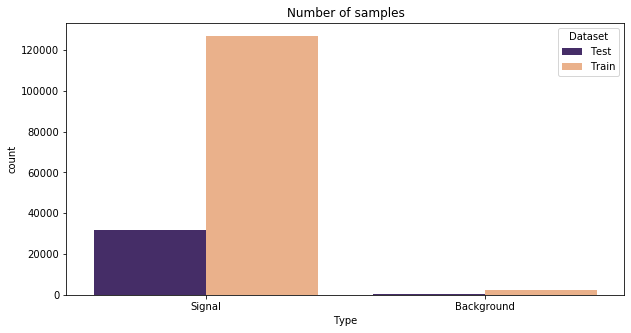

In [9]:
import seaborn as sns
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(x="Type", data=df_final, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B"])
axes.set_title("Number of samples")
#axes.set_yscale("log")
plt.savefig(OutputDirName+"/TotalStat_TrainANDTest.png")
    

 Making training dataset feature plots


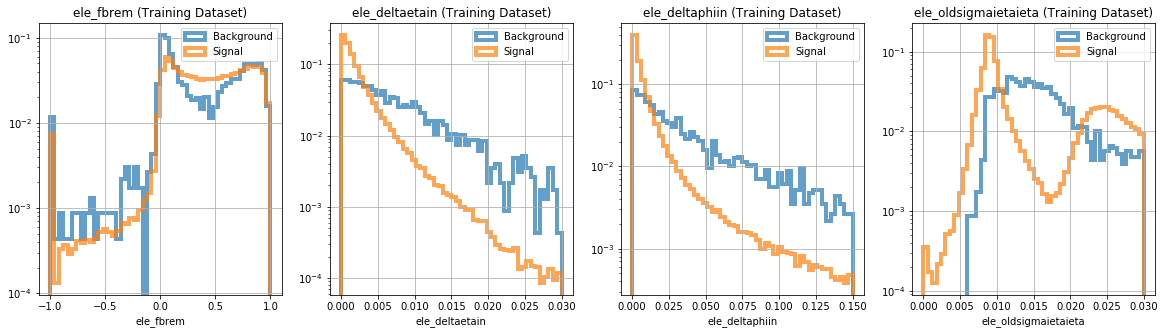

In [10]:
fig, axes = plt.subplots(1, len(features), figsize=(len(features)*5, 5))
prGreen("Making training dataset feature plots")
for m in range(len(features)):
    for i,group_df in df_final[df_final['Dataset'] == "Train"].groupby(cat):
        group_df[features[m-1]].hist(histtype='step', bins=feature_bins[m-1], alpha=0.7,label=label[i], ax=axes[m-1], density=False, ls='-', weights =group_df[weight]/group_df[weight].sum(),linewidth=4)
        #df_new = pd.concat([group_df, df_new],ignore_index=True, sort=False)                                                                                            
    axes[m-1].legend(loc='upper right')
    axes[m-1].set_xlabel(features[m-1])
    axes[m-1].set_yscale("log")
    axes[m-1].set_title(features[m-1]+" (Training Dataset)")
plt.savefig(OutputDirName+"/featureplots_Training.png")

 Making testing dataset feature plots


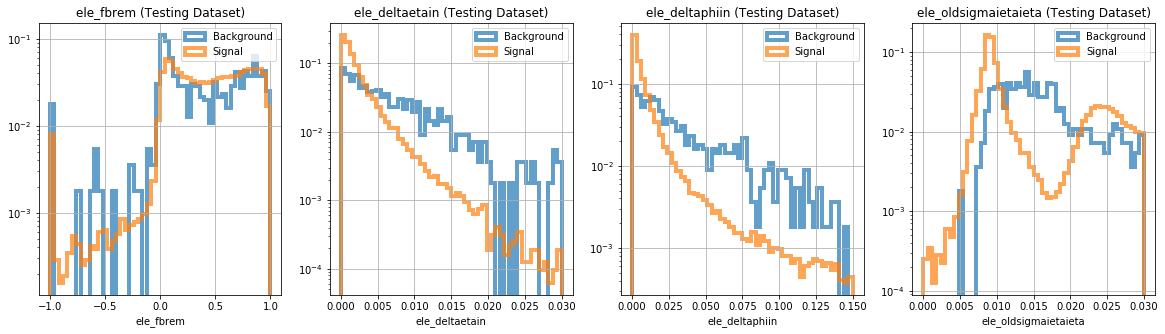

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, len(features), figsize=(len(features)*5, 5))
prGreen("Making testing dataset feature plots")
for m in range(len(features)):
    for i,group_df in df_final[df_final['Dataset'] == "Test"].groupby(cat):
        group_df[features[m-1]].hist(histtype='step', bins=feature_bins[m-1], alpha=0.7,label=label[i], ax=axes[m-1], density=False, ls='-', weights =group_df[weight]/group_df[weight].sum(),linewidth=4)
        #df_new = pd.concat([group_df, df_new],ignore_index=True, sort=False)                                                                                            
    axes[m-1].legend(loc='upper right')
    axes[m-1].set_xlabel(features[m-1])
    axes[m-1].set_yscale("log")
    axes[m-1].set_title(features[m-1]+" (Testing Dataset)")
plt.savefig(OutputDirName+"/featureplots_Testing.png")

In [12]:
X_train = df_final.loc[TrainIndices,features]
Y_train = df_final.loc[TrainIndices,cat]
Wt_train = df_final.loc[TrainIndices,weight]
    
X_test = df_final.loc[TestIndices,features]
Y_test = df_final.loc[TestIndices,cat]
Wt_test = df_final.loc[TestIndices,weight]

X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
Wt_train = np.asarray(Wt_train)
    
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
Wt_test = np.asarray(Wt_test)

 XGB Training starting
 Performing XGB grid search
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] learning_rate=0.1 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ learning_rate=0.1, total=   4.6s
[CV] learning_rate=0.1 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] ................................ learning_rate=0.1, total=   4.5s
[CV] learning_rate=0.1 ...............................................
[CV] ................................ learning_rate=0.1, total=   3.9s
[CV] learning_rate=0.01 ..............................................
[CV] ............................... learning_rate=0.01, total=   3.8s
[CV] learning_rate=0.01 ..............................................
[CV] ............................... learning_rate=0.01, total=   3.6s
[CV] learning_rate=0.01 ..............................................
[CV] ............................... learning_rate=0.01, total=   3.6s
[CV] learning_rate=0.001 .............................................
[CV] .............................. learning_rate=0.001, total=   3.6s
[CV] learning_rate=0.001 .............................................
[CV] .............................. learning_rate=0.001, total=   3.7s
[CV] learning_rate=0.001 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   35.0s finished


 Expected accuracy of XGB model = 98.3%
 XGB Best Parameters
 {'learning_rate': 0.1}
 Plotting output response for XGB
 Plotting ROC for XGB


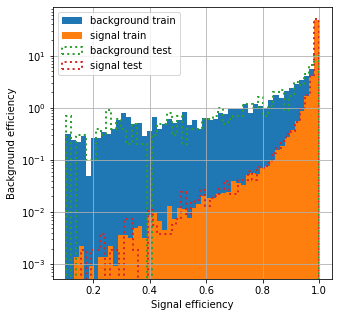

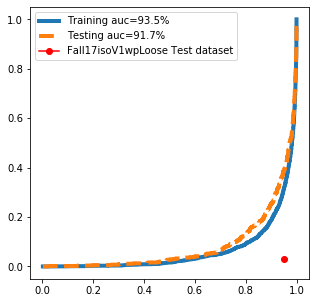

In [13]:
if 'XGB' in MVAs:
    prGreen("XGB Training starting")
    import xgboost as xgb
    from sklearn.model_selection import cross_val_score, GridSearchCV
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=RandomState)
    #xgb_model.set_config(verbosity=2)
    prGreen("Performing XGB grid search")
    cv = GridSearchCV(xgb_model, XGBGridSearch,scoring = 'accuracy',cv=3,verbose=1)
    search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=1)

    prGreen("Expected accuracy of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
    #prGreen("Expected accuracy of XGB model = "+str((np.average(search.best_score_))*100)+'%')
    prGreen("XGB Best Parameters")
    
    #json.dumps(search.best_params_)
    prGreen(str(search.best_params_))
    
    df_final.loc[TrainIndices,"xgb_pred"]=cv.predict_proba(X_train)[:,1]
    df_final.loc[TestIndices,"xgb_pred"]=cv.predict_proba(X_test)[:,1]
    
    prGreen("Plotting output response for XGB")
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    plot_mva(df_final.query('TrainDataset==1'),"xgb_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='train',ls='dashed',logscale=True)
    plot_mva(df_final.query('TrainDataset==0'),"xgb_pred",bins=50,cat=cat,Wt=weight,ax=axes,sample='test',ls='dotted',logscale=True)
    axes.set_ylabel("Background efficiency")
    axes.set_xlabel("Signal efficiency")
    axes.set_title("XGB")
    plt.savefig(OutputDirName+"/XGBMVA.png")
    
    prGreen("Plotting ROC for XGB")
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    plot_roc_curve(df_final.query('TrainDataset==1'),"xgb_pred", tpr_threshold=0, ax=axes, color=None, linestyle='-', label='Training',cat=cat,Wt=weight)
    plot_roc_curve(df_final.query('TrainDataset==0'),"xgb_pred", tpr_threshold=0, ax=axes, color=None, linestyle='--', label='Testing',cat=cat,Wt=weight)
    if len(OverlayWP)>0:
        for OverlayWpi in OverlayWP:
            plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, marker='o', markersize=6, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
    plt.savefig(OutputDirName+"/XGBROC.png")

 DNN fitting running
Train on 129114 samples, validate on 32279 samples
Epoch 1/5
129114/129114 [==============================] - 2s 17us/sample - loss: 0.0855 - acc: 0.9821 - val_loss: 0.0783 - val_acc: 0.9827
Epoch 2/5
129114/129114 [==============================] - 2s 15us/sample - loss: 0.0831 - acc: 0.9822 - val_loss: 0.0768 - val_acc: 0.9827
Epoch 3/5
129114/129114 [==============================] - 2s 17us/sample - loss: 0.0810 - acc: 0.9822 - val_loss: 0.0757 - val_acc: 0.9827
Epoch 4/5
129114/129114 [==============================] - 2s 16us/sample - loss: 0.0792 - acc: 0.9822 - val_loss: 0.0746 - val_acc: 0.9827
Epoch 5/5
129114/129114 [==============================] - 2s 16us/sample - loss: 0.0781 - acc: 0.9822 - val_loss: 0.0738 - val_acc: 0.9827
 Plotting output response for XGB
 Plotting ROC for XGB


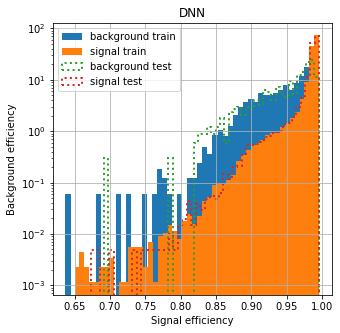

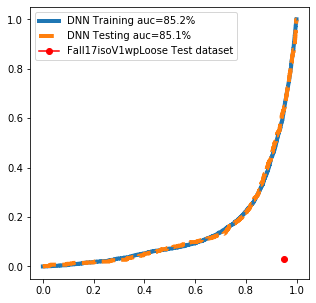

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
if 'DNN' in MVAs:
    prGreen("DNN fitting running")
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    modelDNN.compile(loss='binary_crossentropy', optimizer=Adam(lr=DNNDict['lr']), metrics=['accuracy',])
    train_history = modelDNN.fit(X_train,Y_train,epochs=DNNDict['epochs'],batch_size=DNNDict['batchsize'],validation_data=(X_test,Y_test, Wt_test),
                                 verbose=1,callbacks=[es], sample_weight=Wt_train)
    modelDNN.save(OutputDirName+"/modelDNN.h5")
    df_final.loc[TrainIndices,"scoreDNN"]=modelDNN.predict(X_train)
    df_final.loc[TestIndices,"scoreDNN"]=modelDNN.predict(X_test)
    
    prGreen("Plotting output response for DNN")
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    plot_mva(df_final.query('TrainDataset==1'),"scoreDNN",bins=50,cat=cat,Wt=weight,ax=axes,sample='train',ls='dashed',logscale=True)
    plot_mva(df_final.query('TrainDataset==0'),"scoreDNN",bins=50,cat=cat,Wt=weight,ax=axes,sample='test',ls='dotted',logscale=True)
    axes.set_ylabel("Background efficiency")
    axes.set_xlabel("Signal efficiency")
    axes.set_title("DNN")
    plt.savefig(OutputDirName+"/DNNMVA.png")
    
    prGreen("Plotting ROC for DNN")
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    plot_roc_curve(df_final.query('TrainDataset==1'),"scoreDNN", tpr_threshold=0, ax=axes, color=None, linestyle='-', label='DNN Training',cat=cat,Wt=weight)
    plot_roc_curve(df_final.query('TrainDataset==0'),"scoreDNN", tpr_threshold=0, ax=axes, color=None, linestyle='--', label='DNN Testing',cat=cat,Wt=weight)
    if len(OverlayWP)>0:
        for OverlayWpi in OverlayWP:
            plot_single_roc_point(df_final.query('TrainDataset==0'), var=OverlayWpi, ax=axes, marker='o', markersize=6, label=OverlayWpi+" Test dataset", cat=cat,Wt=weight)
    plt.savefig(OutputDirName+"/DNNROC.png")

In [ ]:
if 'Genetic' in MVAs:
    prGreen("Sorry Genetic algo not implemented yet! Coming Soon")

In [ ]:
os.system("convert "+OutputDirName+"/featureplots_T* "+OutputDirName+"/TotalStat_TrainANDTest.png "+OutputDirName+"/XGB* Output/DNN* "+OutputDirName+"/mydoc.pdf")
prGreen("Done!! Please find the quick look pdf here "+OutputDirName+"/mydoc.pdf")